<a href="https://colab.research.google.com/github/michelgawron/LSTM_exp/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from random import choices, choice

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.manual_seed(1)

In [0]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!ls
!unzip household_power_consumption.zip

--2019-06-05 12:55:07--  http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip’

household_power_con 100%[===================>]  19.68M  14.3MB/s    in 1.4s    

2019-06-05 12:55:09 (14.3 MB/s) - ‘household_power_consumption.zip’ saved [20640916/20640916]

household_power_consumption.zip  sample_data
Archive:  household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [0]:
!ls
!unzip household_power_consumption.zip

household_power_consumption.txt  household_power_consumption.zip  sample_data
Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import pandas as pd

my_df = pd.read_csv("./household_power_consumption.txt", sep=";", parse_dates={'dt': ["Date", "Time"]}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'], index_col='dt')
my_df.head(5)

Global_active_power  ...  Sub_metering_3
dt                                        ...                
2006-12-16 17:24:00                4.216  ...            17.0
2006-12-16 17:25:00                5.360  ...            16.0
2006-12-16 17:26:00                5.374  ...            17.0
2006-12-16 17:27:00                5.388  ...            17.0
2006-12-16 17:28:00                3.666  ...            17.0

[5 rows x 7 columns]

In [0]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [0]:
my_df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [0]:
# Checking for null values in the dataframe
my_df.isna().any()

Global_active_power      True
Global_reactive_power    True
Voltage                  True
Global_intensity         True
Sub_metering_1           True
Sub_metering_2           True
Sub_metering_3           True
dtype: bool

In [0]:
my_df = my_df.fillna(my_df.median())

In [0]:
# Checking for null values in the dataframe
my_df.isna().any()

Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3           False
dtype: bool

In [0]:
# The shift functions shifts (décale) the index by n rows down if positive, up if negative
my_df.shift(1).dropna().head(5)

Global_active_power  ...  Sub_metering_3
dt                                        ...                
2006-12-16 17:25:00                4.216  ...            17.0
2006-12-16 17:26:00                5.360  ...            16.0
2006-12-16 17:27:00                5.374  ...            17.0
2006-12-16 17:28:00                5.388  ...            17.0
2006-12-16 17:29:00                3.666  ...            17.0

[5 rows x 7 columns]

In [0]:
my_df.shift(-1)["Global_active_power"].head(5)

dt
2006-12-16 17:24:00    5.360
2006-12-16 17:25:00    5.374
2006-12-16 17:26:00    5.388
2006-12-16 17:27:00    3.666
2006-12-16 17:28:00    3.520
Name: Global_active_power, dtype: float64

In [0]:
def generate_dataset(seq_length, data, resampling="h"):
  """
    Using the shift function in order to create a time series dataset.
    We are going to use data from t-5 to t-1 and the ouptut at t.
    For now data is stored in a list (flat storage).
    When creating the dataset we are going to store info about a single timestep
    separately (each timestep is going to be a single vector stored in a tensor)
  """
  cols = []
  for i in range(seq_length, 0, -1):
    cols.append(data.shift(i))
  print(len(cols))
  
  # Joining columns
  cols.append(data.shift(0)["Global_active_power"])
  seq_df = pd.concat(cols, axis=1)
  seq_df = seq_df.dropna()
  seq_df.columns = ["var%d(t-n)" % i for i in range(len(seq_df.columns) - 1)] + ["var0(t)"]
  
  # Resampling columns
  df_resample = seq_df.resample(resampling).sum()
  
  # Scaling columns
  scaler = StandardScaler()
  scaled = pd.DataFrame(scaler.fit_transform(df_resample))
  scaled.index = df_resample.index
  scaled.columns = df_resample.columns
  
  # Getting values and creating train-test datasets
  values = scaled.values
  # Each row of our list contains t-5 to t-1 values and the output at t
  # Getting first year values to train
  train_time = 365*24 if resampling =="h" else 365 if resampling == "d" else 365*24*6
  train = values[:train_time, :]
  test = values[train_time:, :]

  # Getting all of values except the last one for X, the last one for y
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # Reshaping our data to fit in a tensor of shape (batch, seq_len, input_len)
  #train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  train_X = train_X.reshape((train_X.shape[0], seq_length, 7))
  test_X = test_X.reshape((test_X.shape[0], seq_length, 7))
  
  # Storing data in a tensor
  trainX_tensor = torch.tensor(train_X)
  testX_tensor = torch.tensor(test_X)

  # Converting y to right output (shape=(batch_size, 1) as we have 1 dim output)
  trainY_tensor = torch.tensor(train_y).float().view(-1, 1)
  testY_tensor = torch.tensor(test_y).float().view(-1, 1)
  
  return trainX_tensor, testX_tensor, trainY_tensor, testY_tensor, scaler
  
trainX_tensor_3, testX_tensor_3, trainY_tensor_3, testY_tensor_3, scaler_3 = generate_dataset(3, my_df, '10T')
trainX_tensor_5, testX_tensor_5, trainY_tensor_5, testY_tensor_5, scaler_5 = generate_dataset(5, my_df, '10T')
print(
    trainX_tensor_3.shape,
    testX_tensor_3.shape,
    trainY_tensor_3.shape,
    testY_tensor_3.shape,
    trainX_tensor_5.shape,
    testX_tensor_5.shape,
    trainY_tensor_5.shape,
    testY_tensor_5.shape,
)

3
5
torch.Size([52560, 3, 7]) torch.Size([154967, 3, 7]) torch.Size([52560, 1]) torch.Size([154967, 1]) torch.Size([52560, 5, 7]) torch.Size([154967, 5, 7]) torch.Size([52560, 1]) torch.Size([154967, 1])


In [0]:
trainX_tensor_3[0:3]

tensor([[[ 4.0786e-01,  1.1991e-01, -5.3527e+01,  4.3599e-01, -2.0902e-01,
          -1.6391e-01, -1.7038e-01],
         [ 5.2460e-01,  2.0537e-01, -5.3561e+01,  5.4515e-01, -2.0902e-01,
          -1.6396e-01, -1.7037e-01],
         [ 3.5588e-01,  2.9892e-01, -5.3498e+01,  3.7431e-01, -2.0891e-01,
          -1.6401e-01, -1.5811e-01]],

        [[ 3.1407e+00,  3.8912e+00, -2.1068e+00,  3.2309e+00, -2.0902e-01,
          -1.5282e-02,  1.2760e+00],
         [ 3.1289e+00,  3.7851e+00, -2.1328e+00,  3.2215e+00, -2.0902e-01,
           3.2974e-03,  1.2759e+00],
         [ 3.1674e+00,  3.6764e+00, -2.1467e+00,  3.2641e+00, -2.0891e-01,
           3.2984e-03,  1.2758e+00]],

        [[ 3.6024e+00,  1.7893e-01, -1.8967e+00,  3.7006e+00, -2.0902e-01,
          -1.8249e-01,  1.2882e+00],
         [ 3.5932e+00, -2.2607e-01, -1.8565e+00,  3.6865e+00, -2.0902e-01,
          -2.1972e-01,  1.2881e+00],
         [ 3.6349e+00, -6.5532e-01, -1.8653e+00,  3.7291e+00, -2.0891e-01,
          -2.3836e-01,  1

In [0]:
class myModel(nn.Module):
  """
  Definition of our model
  """
  
  def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
    """
      Defining a LSTM model - parameters speaks for themselves
    """
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, dropout=0.3)
    
    self.linear = nn.Linear(self.hidden_dim, output_dim)
    
  def init_hidden(self, size):
    """
        We need to create two empty vectors to store hn and cn at initial state
    """
    return (torch.zeros(self.num_layers, size, self.hidden_dim).to(device),
           torch.zeros(self.num_layers, size, self.hidden_dim).to(device))
  
  def forward(self, input):
    """
      Computes a single forward pass on our input batch
    """
    #print(input.shape)
    #print(len(input))
    h0, c0 = self.init_hidden(input.size(0))
    out, (h0, c0) = self.lstm(input, (h0, c0))
    out = self.linear(out[:, -1, :])
    #print(out.view(-1).shape)
    return out

In [0]:
# Dynamic lr and batch size
batch_size = [128, 256, 512]
#batch_size = [16, 32, 64]
lrs = [0.01, 0.001, 0.0001]
seq_sizes = [3, 5]

In [0]:
# Generating model and sending it to gpu
model = myModel(7, 500, num_layers=3).to(device)
#optim = torch.optim.Adam(model.parameters(), lr=lr)
#model.hidden = model.init_hidden()

Batch size: 128
Training loss: 4.556948184967041
Test MAE = 0.13840237259864807
Test MSE = 622.8944091796875
Test R² = 0.969236078680086
----------
Batch size: 128
Training loss: 2.097144842147827
Test MAE = 0.08446014672517776
Test MSE = 239.46217346191406
Test R² = 0.988173282701569
----------


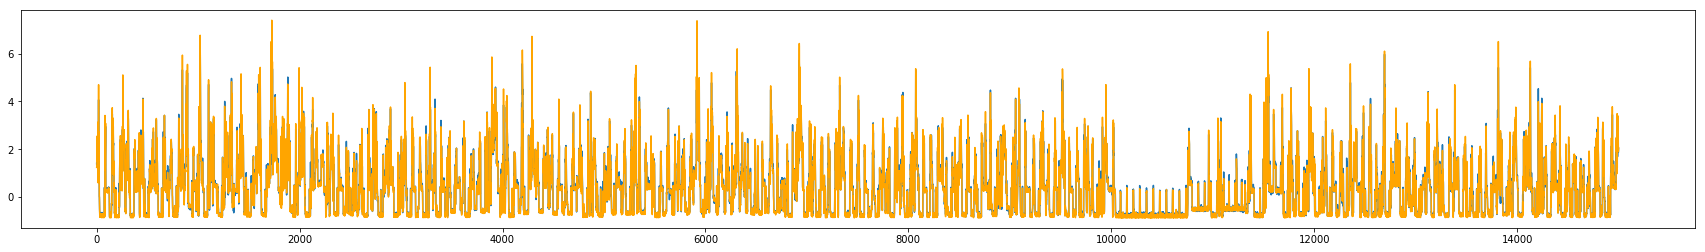

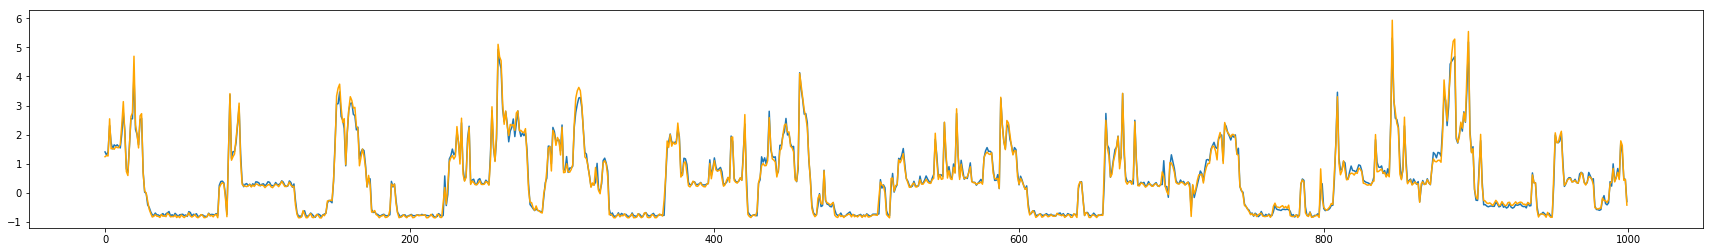

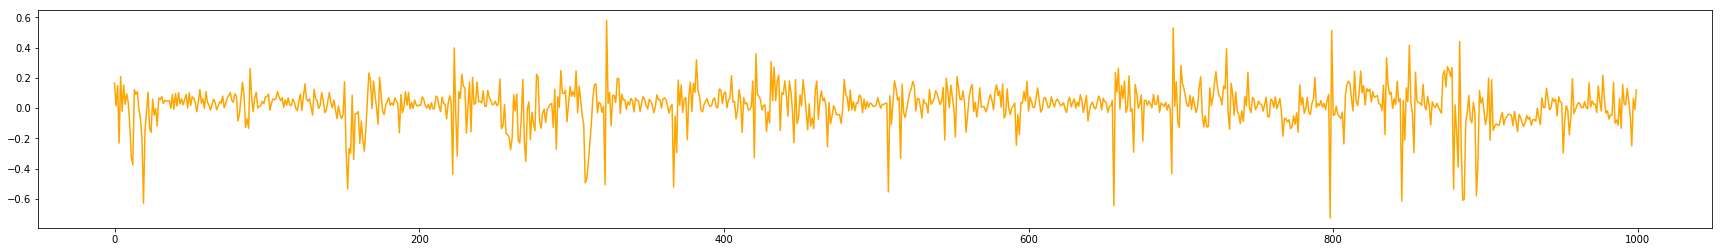

----------
Batch size: 128
Training loss: 1.3461799621582031
Test MAE = 0.0701151192188263
Test MSE = 172.19207763671875
Test R² = 0.991495662318005
----------
Batch size: 128
Training loss: 1.4994803667068481
Test MAE = 0.07299477607011795
Test MSE = 175.68777465820312
Test R² = 0.9913230156894293
----------


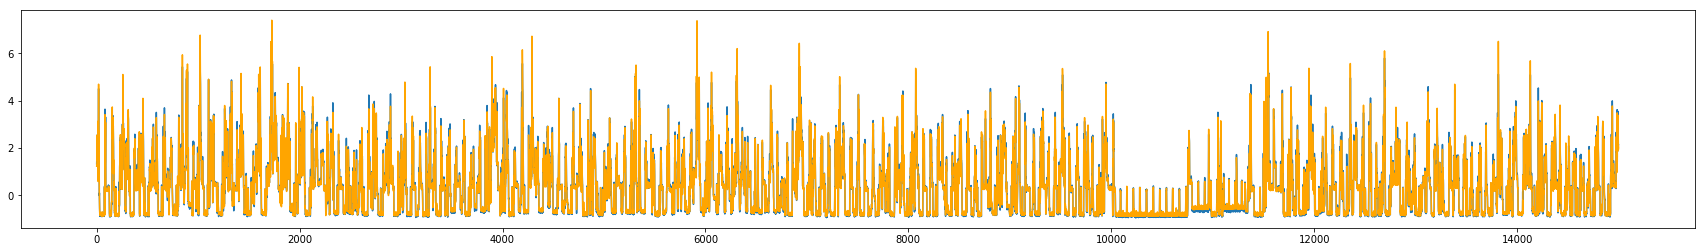

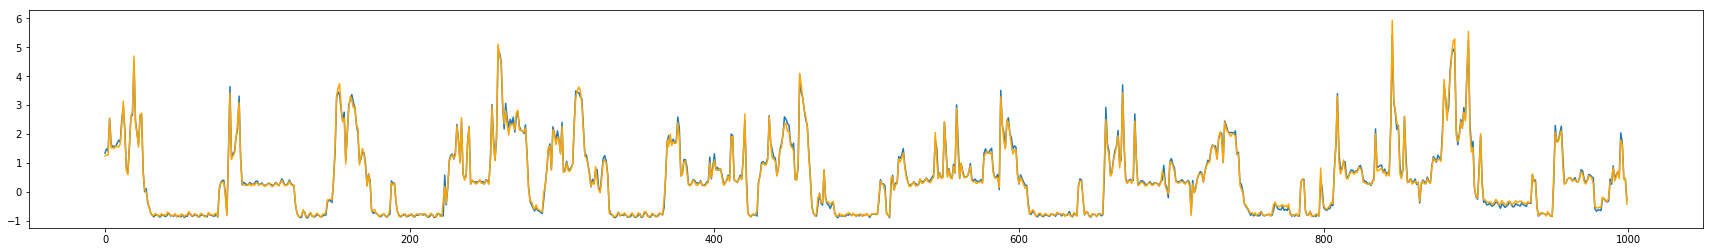

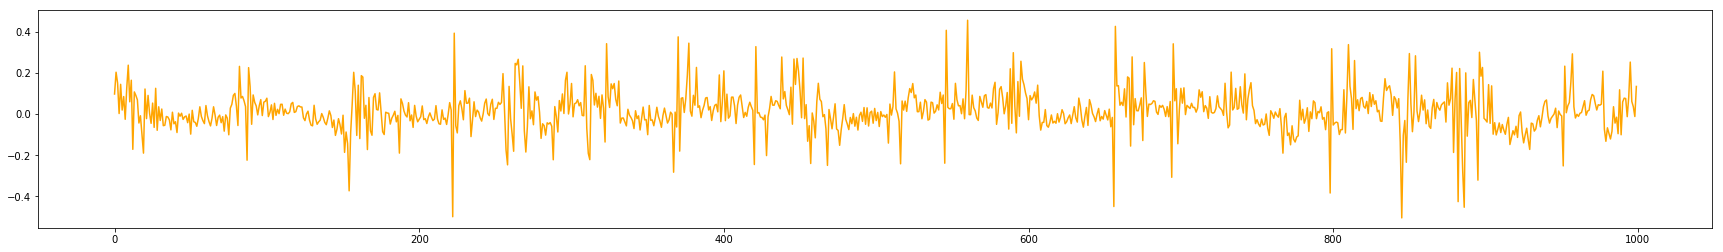

----------
Batch size: 128
Training loss: 1.0006247758865356
Test MAE = 0.05888587236404419
Test MSE = 128.44345092773438
Test R² = 0.9936563497565266
----------
Batch size: 128
Training loss: 1.8094573020935059
Test MAE = 0.05833655595779419
Test MSE = 127.94284057617188
Test R² = 0.9936810736769492
----------


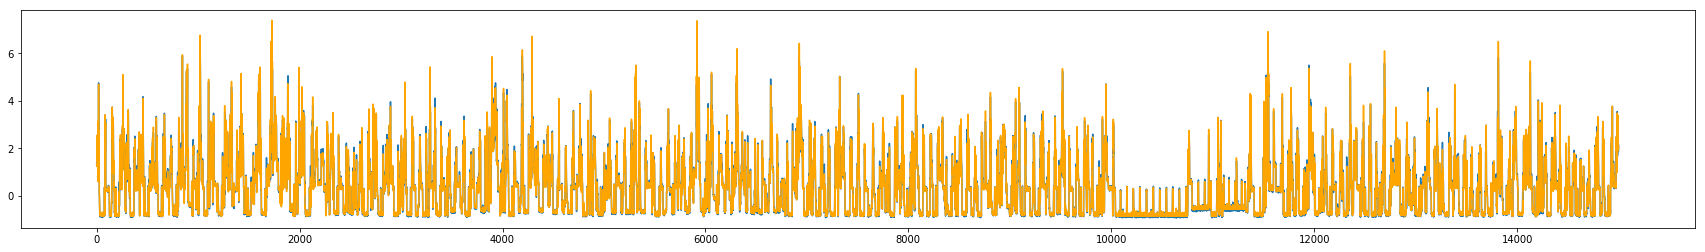

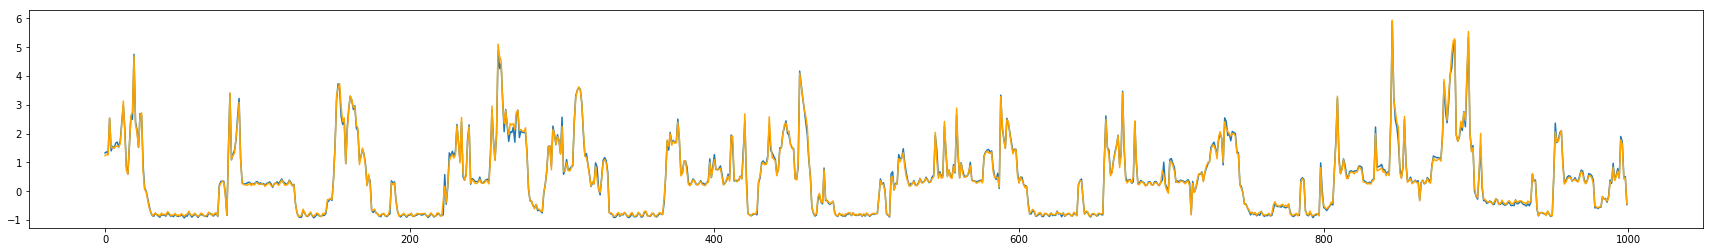

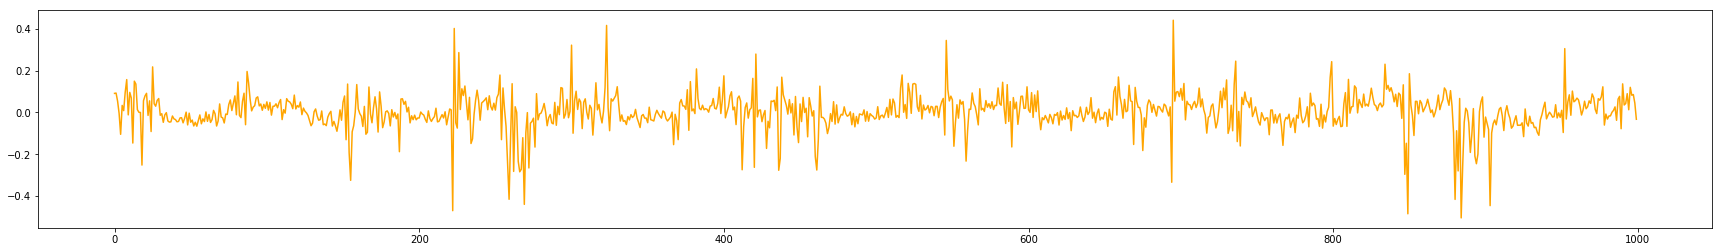

----------
Batch size: 256
Training loss: 0.7569040060043335
Test MAE = 0.03781462460756302
Test MSE = 58.88612365722656
Test R² = 0.99709169304723
----------
Batch size: 256
Training loss: 0.7780581116676331
Test MAE = 0.03551463037729263
Test MSE = 51.537696838378906
Test R² = 0.9974546220230526
----------


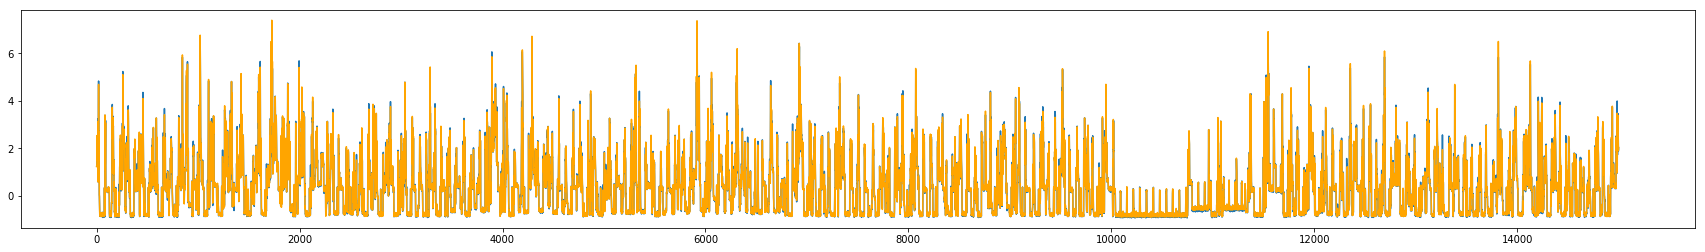

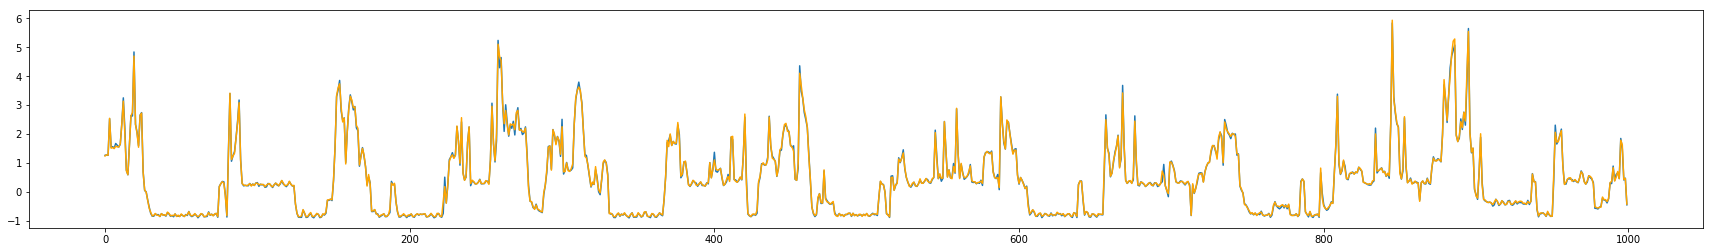

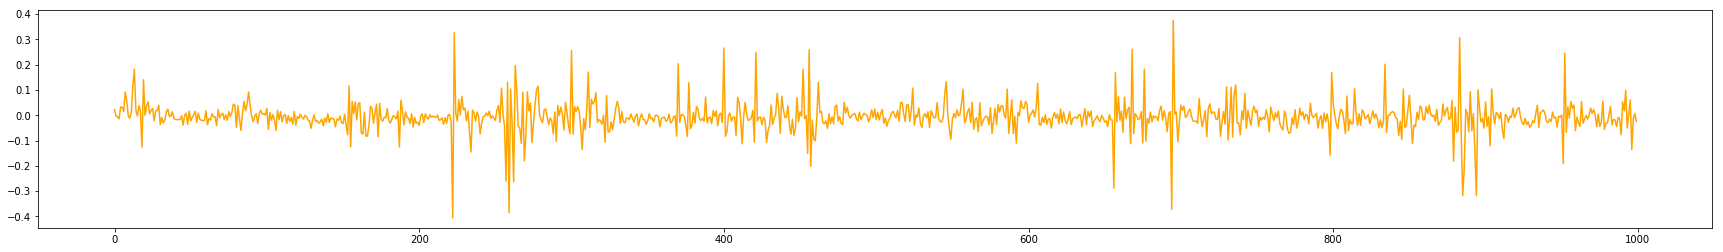

----------
Batch size: 256
Training loss: 0.5138486623764038
Test MAE = 0.03331663832068443
Test MSE = 49.64085388183594
Test R² = 0.9975483045310107
----------
Batch size: 256
Training loss: 0.832115888595581
Test MAE = 0.03320067375898361
Test MSE = 45.52052307128906
Test R² = 0.9977518021414887
----------


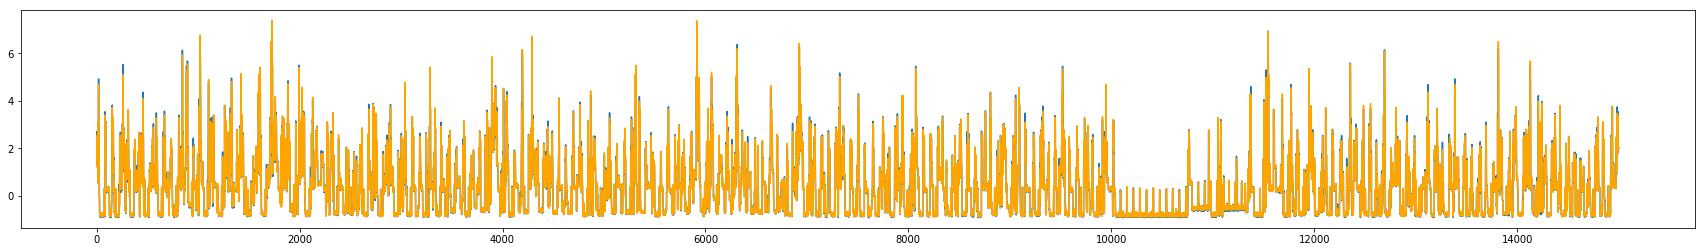

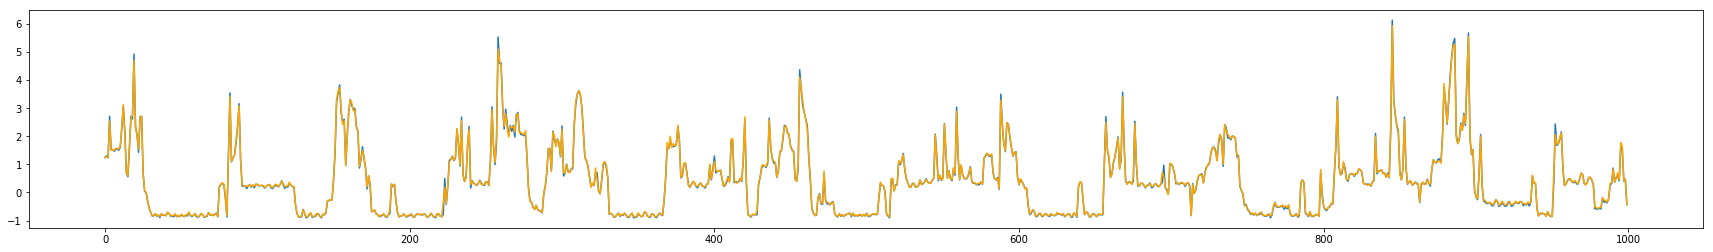

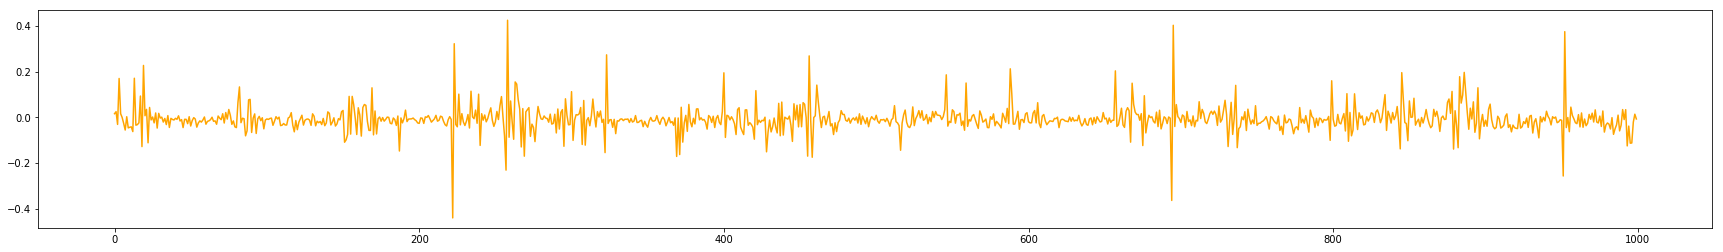

----------
Batch size: 256
Training loss: 0.6337752342224121
Test MAE = 0.03320961073040962
Test MSE = 43.9495849609375
Test R² = 0.9978293887646459
----------
Batch size: 256
Training loss: 0.5186941623687744
Test MAE = 0.03526761755347252
Test MSE = 45.23842239379883
Test R² = 0.9977657346260398
----------


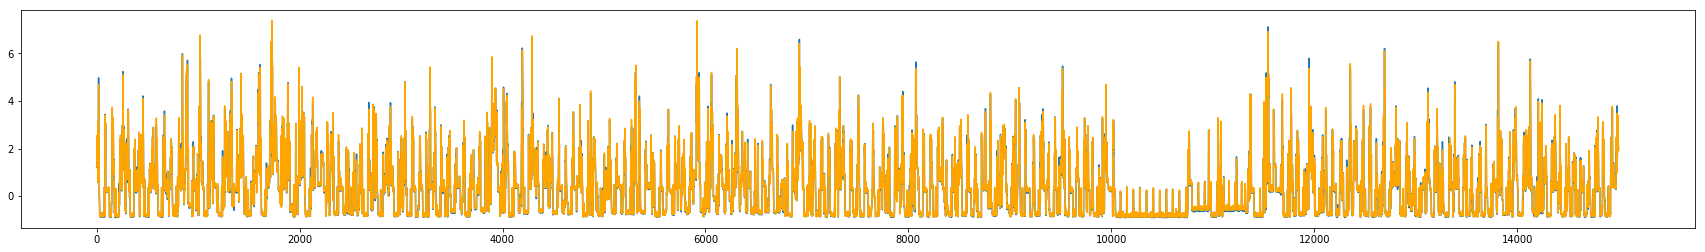

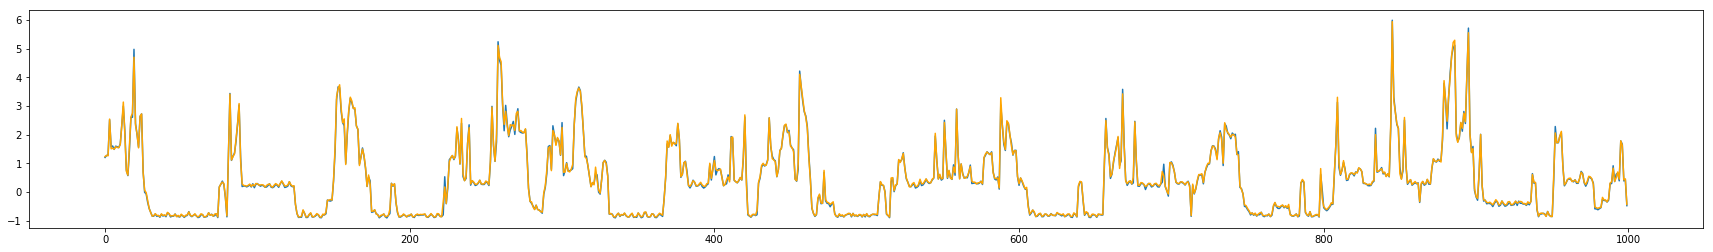

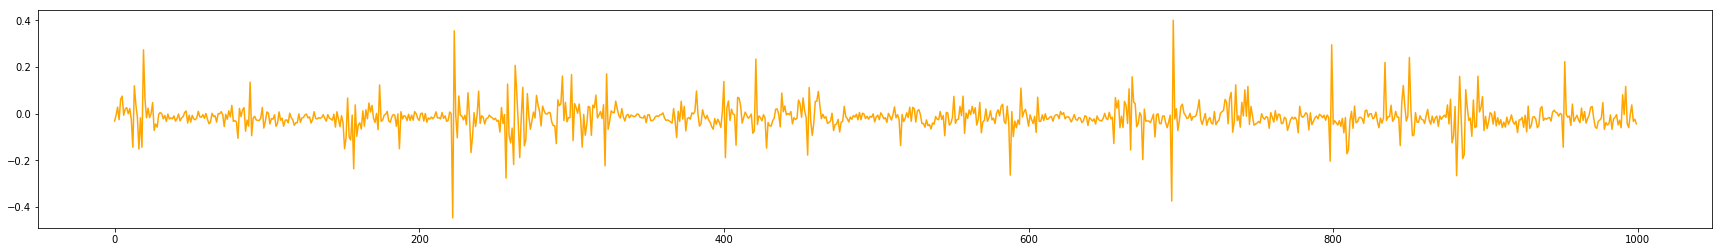

----------
Batch size: 512
Training loss: 0.9738216400146484
Test MAE = 0.028560079634189606
Test MSE = 37.1245002746582
Test R² = 0.998166470488288
----------
Batch size: 512
Training loss: 1.0159574747085571
Test MAE = 0.028687991201877594
Test MSE = 37.884891510009766
Test R² = 0.9981289159055878
----------


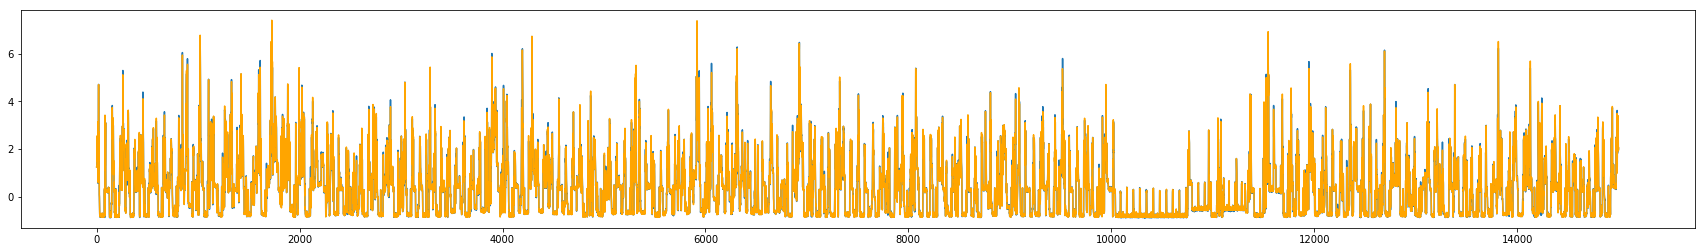

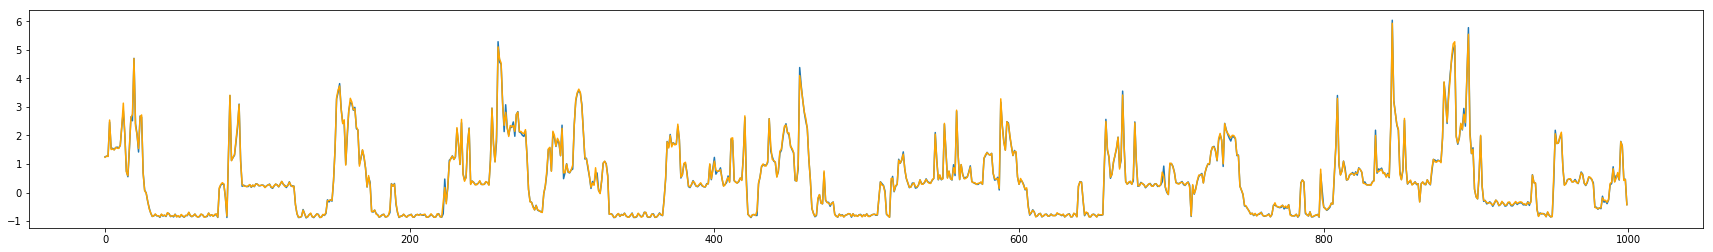

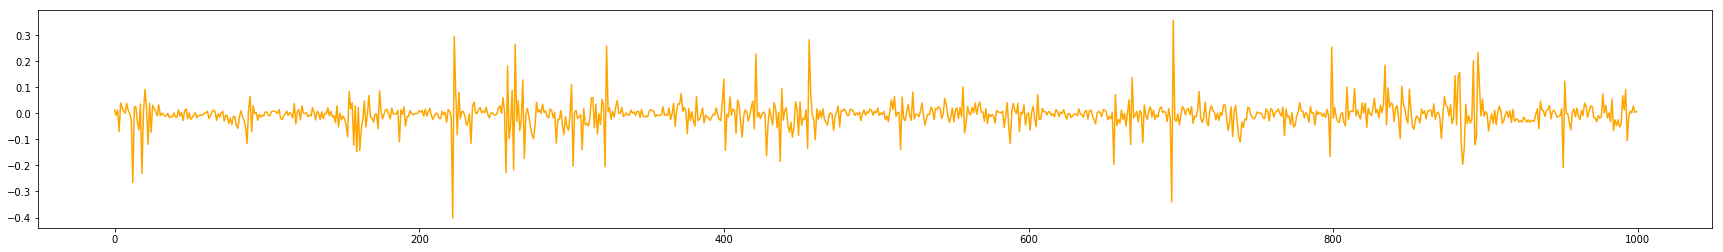

----------
Batch size: 512
Training loss: 1.1401201486587524
Test MAE = 0.028103388845920563
Test MSE = 36.27782440185547
Test R² = 0.9982082865493056
----------
Batch size: 512
Training loss: 0.919563889503479
Test MAE = 0.0277483481913805
Test MSE = 36.348628997802734
Test R² = 0.9982047898047541
----------


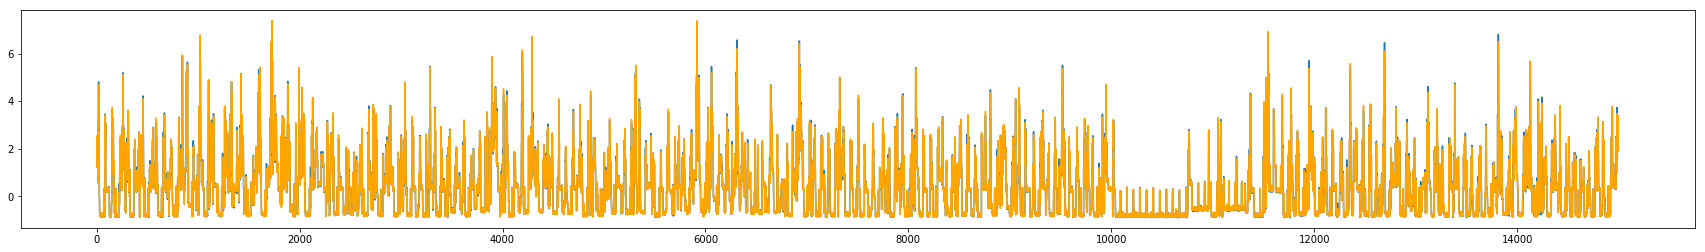

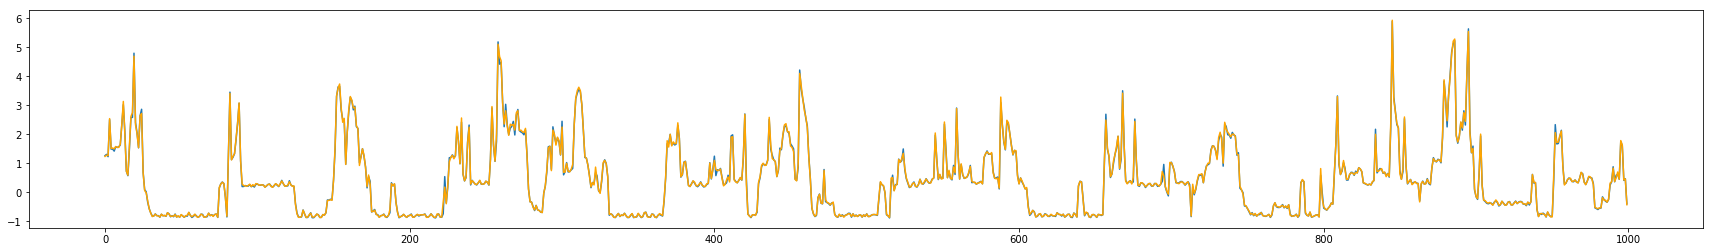

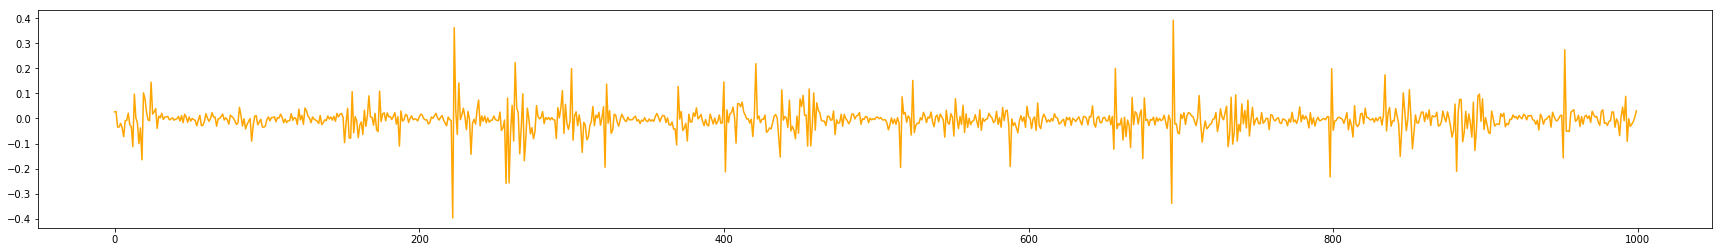

----------
Batch size: 512
Training loss: 1.4156204462051392
Test MAE = 0.027463922277092934
Test MSE = 35.52785873413086
Test R² = 0.9982453265966373
----------
Batch size: 512
Training loss: 1.1952784061431885
Test MAE = 0.027658721432089806
Test MSE = 35.73419189453125
Test R² = 0.9982351360892034
----------


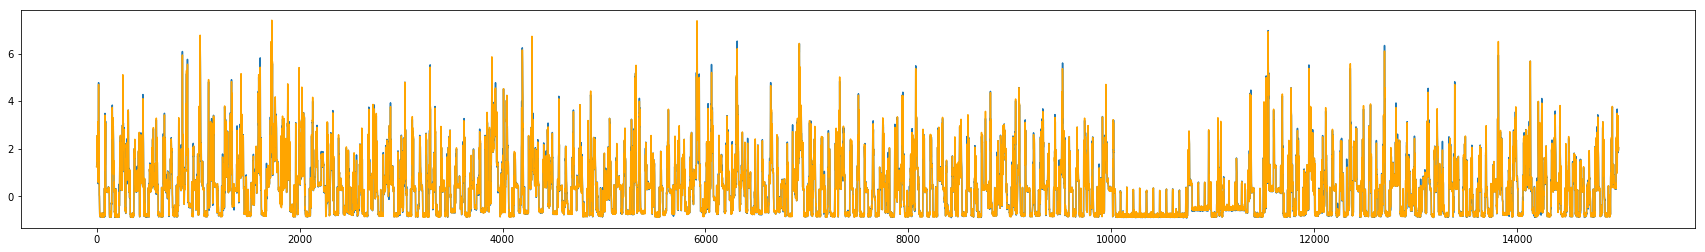

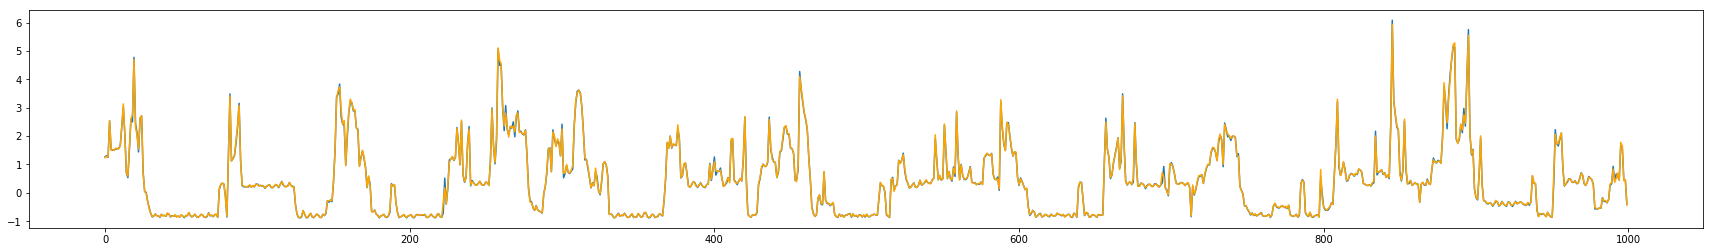

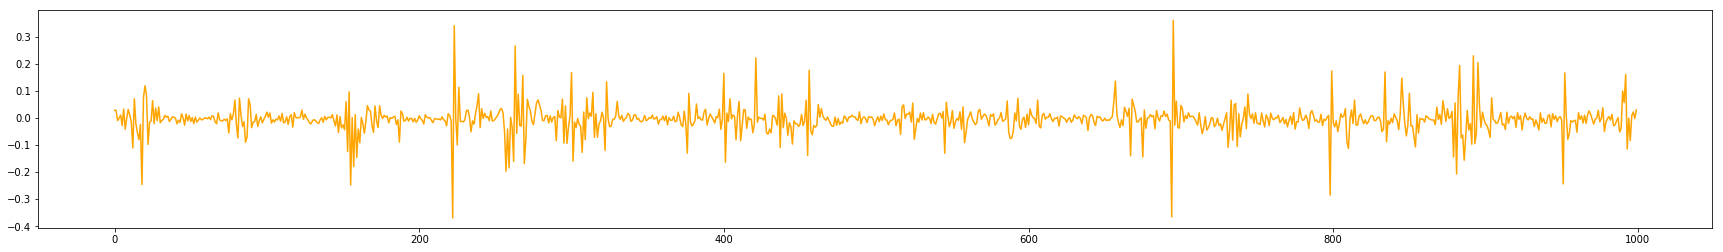

----------


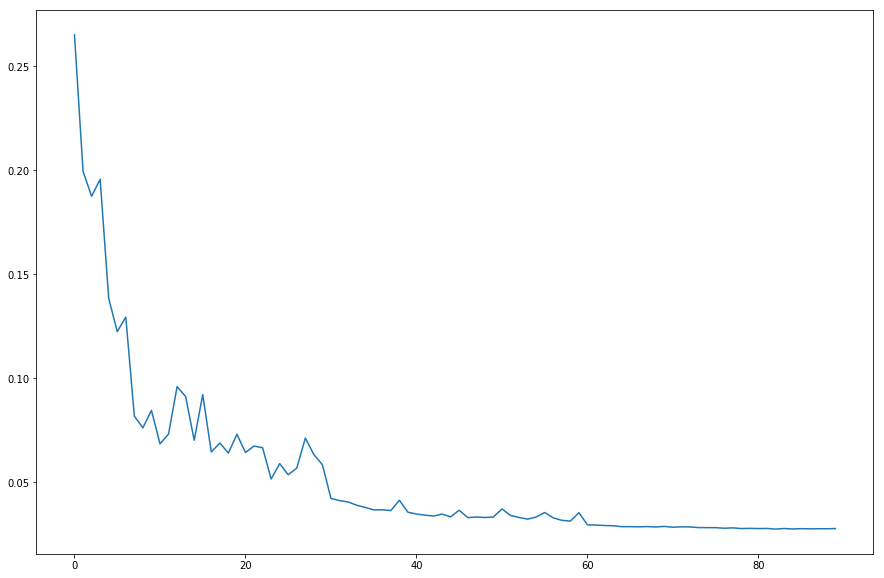

In [0]:
# Training loop - dynamic batch_size and corresponding learning rate
test_loss = []
for my_size, lr in zip(batch_size, lrs):
  # Defining loss function and opitmizer
  loss_fn = torch.nn.MSELoss(reduction="sum")
  optim = torch.optim.Adam(model.parameters(), lr=lr)
  
  # Running training steps for a fixed amount
  for t in range(3000):
    # Getting Xs and Ys from our datasets (coulb be optimized)
    seq_size = choice(seq_sizes)
    if seq_size == 5:
      batch = choices(list(zip(trainX_tensor_5, trainY_tensor_5)), k=my_size)
    else:
      batch = choices(list(zip(trainX_tensor_3, trainY_tensor_3)), k=my_size)
    
    
    # Converting batch to processable tensors and sending them to the gpu
    batchX = torch.cat([el[0] for el in batch]).float().view(my_size, seq_size, 7).to(device)
    batchY = torch.cat([el[1] for el in batch]).float().view(my_size, 1).to(device)
    
    # Reseting gradient
    #model.zero_grad()
    
    # Generating predictions and computing loss
    y_pred = model(batchX)
    loss = loss_fn(y_pred, batchY)
    
    #print(torch.tensor(train_y).float().view(-1).shape)
    
    # Reseting opitmizer and performing backpropagation
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # Computing accuracy every 500 steps and generating graphs
    if (t+1) % 100 == 0:
      # test_size and subset size for loss computing and plotting purpose
      test_size=15000
      subset_size=1000
      with torch.no_grad():
        # Creating two loss functions
        loss_test = torch.nn.L1Loss()
        loss_test_2 = torch.nn.MSELoss(reduction="sum")
        
        # Generating predictions and computing losses
        outputs = model(testX_tensor_5.float()[0:test_size].to(device))
        labels = testY_tensor_5[0:test_size].float().view(-1, 1).to(device)
        mae = loss_test(outputs.data, labels)
        test_loss.append(mae)
        if (t+1) % 500 == 0:
          print(f"Batch size: {my_size}")
          print(f"Training loss: {loss}")
          print(f"Test MAE = {mae}")
          print(f"Test MSE = {loss_test_2(outputs.data, labels)}")
          print(f"Test R² = {r2_score(labels.cpu(), outputs.data.cpu())}")
          print("----------")
        if (t+1) % 1000 == 0:
          # Plotting three figures: whole test batch, a subset and y_pred - y_true
          plt.figure(figsize=(30, 4))
          #plt.plot(outputs.data.numpy() - labels.numpy())
          plt.plot(outputs.data.cpu().numpy())
          plt.plot(labels.cpu().numpy(), 'orange')
          plt.figure(figsize=(30, 4))
          plt.plot(outputs.data.cpu().numpy()[0:subset_size])
          plt.plot(labels.cpu().numpy()[0:subset_size], 'orange')
          plt.figure(figsize=(30, 4))
          plt.plot(outputs.data.cpu().numpy()[0:subset_size] - labels.cpu().numpy()[0:subset_size], 'orange')
          plt.show()
          print("----------")
        
plt.figure(figsize=(15, 10))
plt.plot(test_loss)
plt.show()

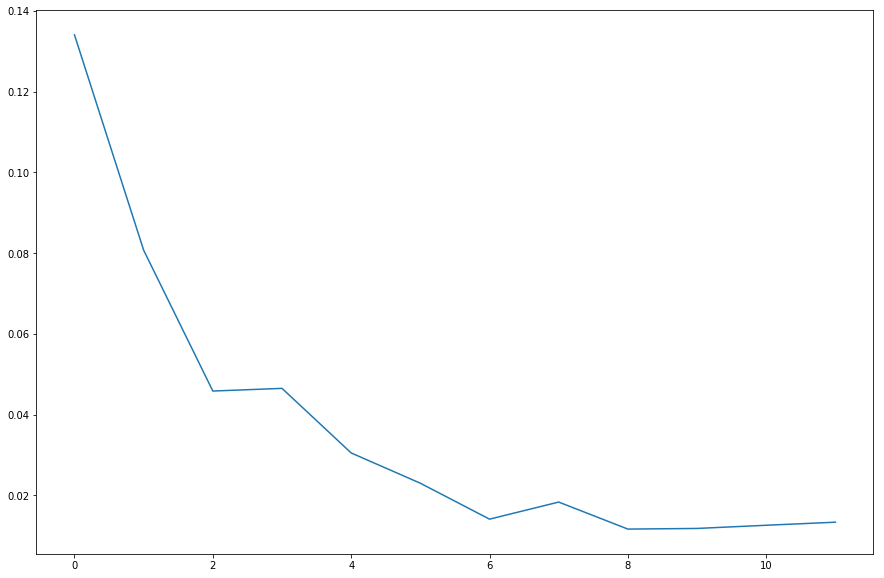

In [0]:
#print(len(testX_tensor))
plt.figure(figsize=(15, 10))
#plt.ylim(0.3, 0.7)
plt.plot(test_loss)
plt.show()

MAE = 0.028686242178082466
R² = 0.9982291827926048
MAE (real values) = 0.3113801181316376
R² (real values) = 0.9982291830307103
----------
MAE = 0.029634976759552956
R² = 0.998160420130363
MAE (real values) = 0.32167962193489075
R² (real values) = 0.9981604202735914
----------


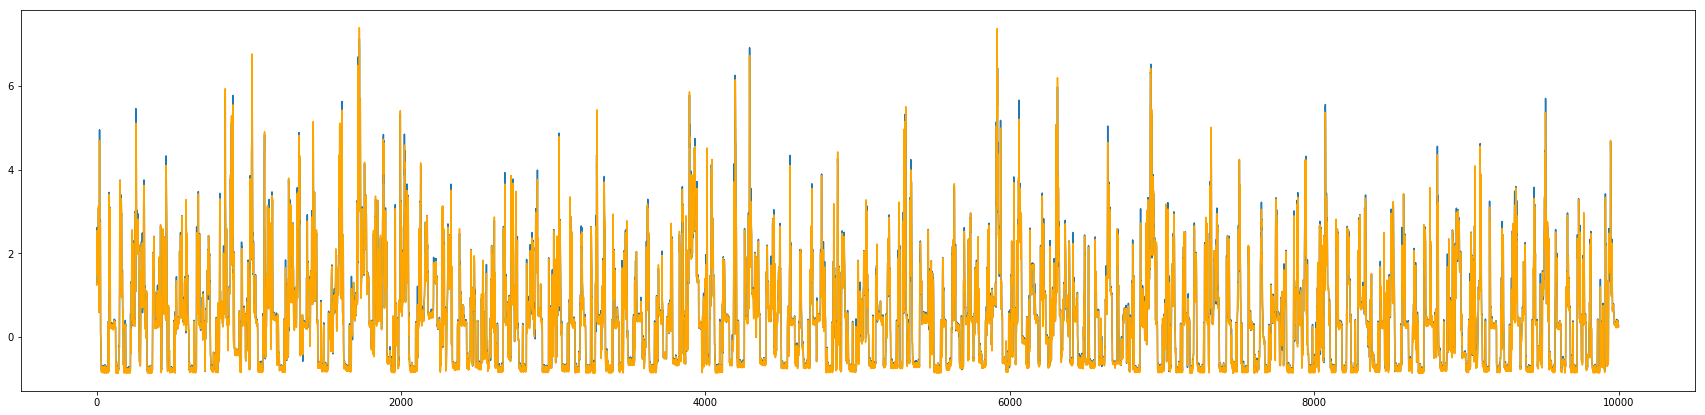

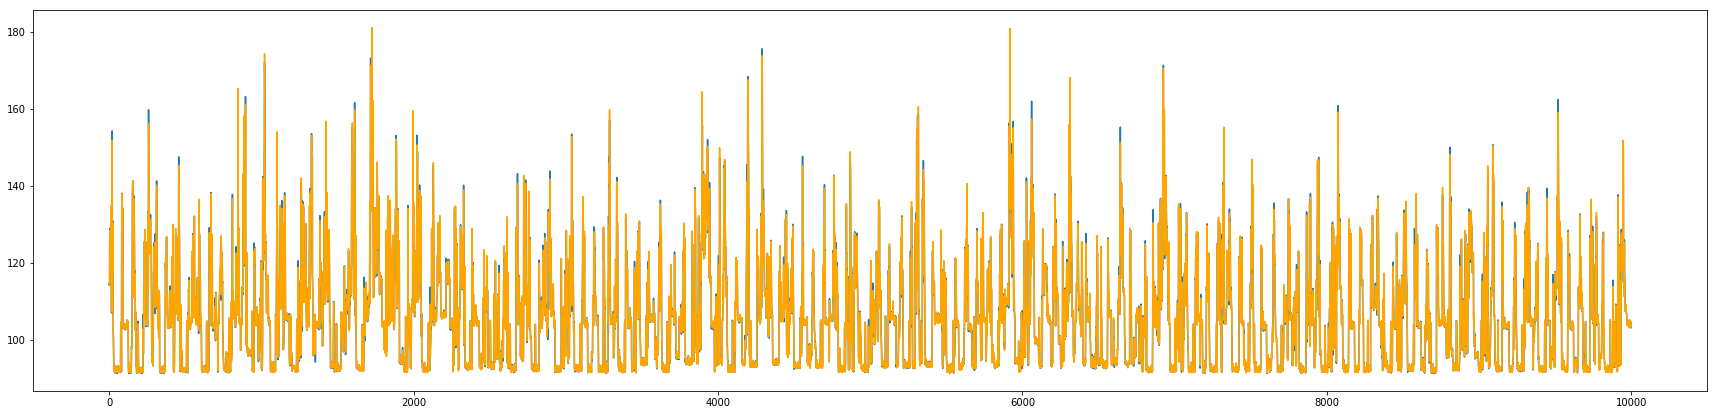

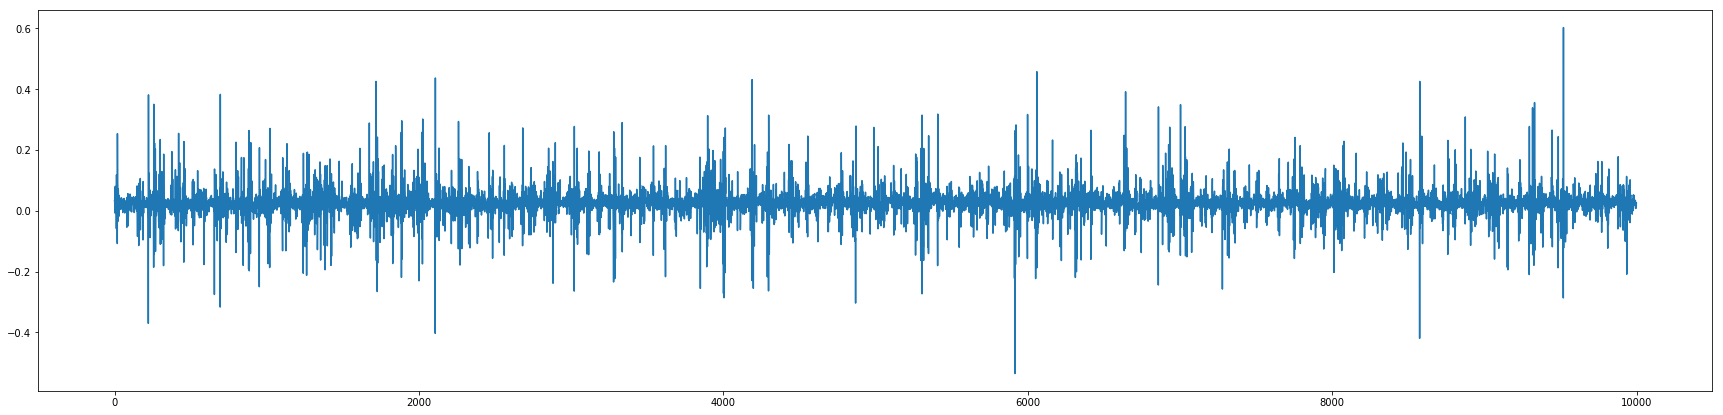

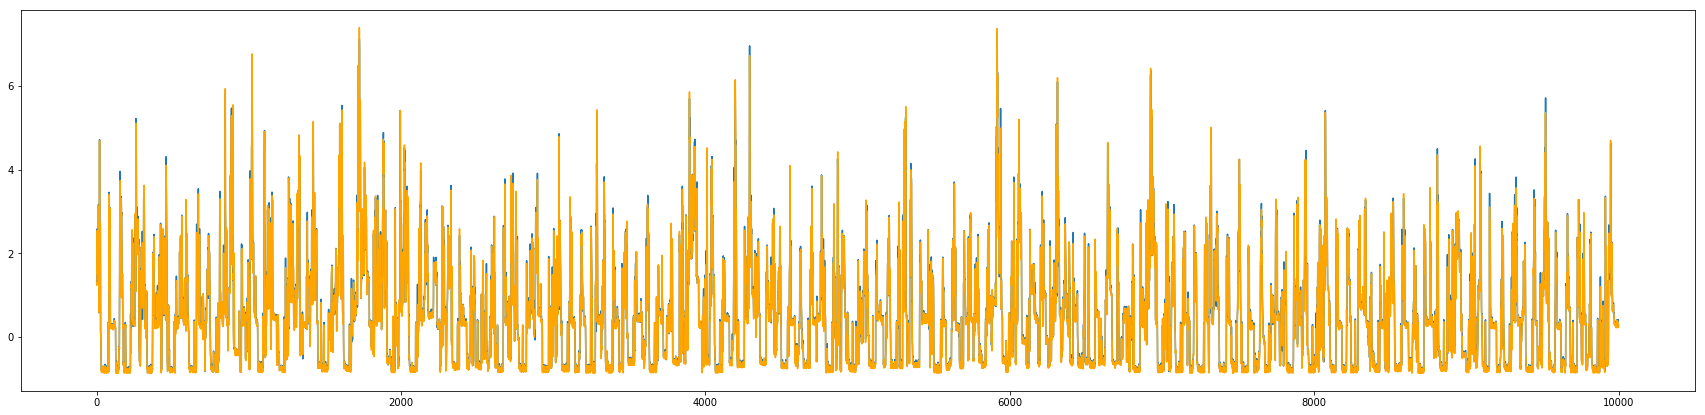

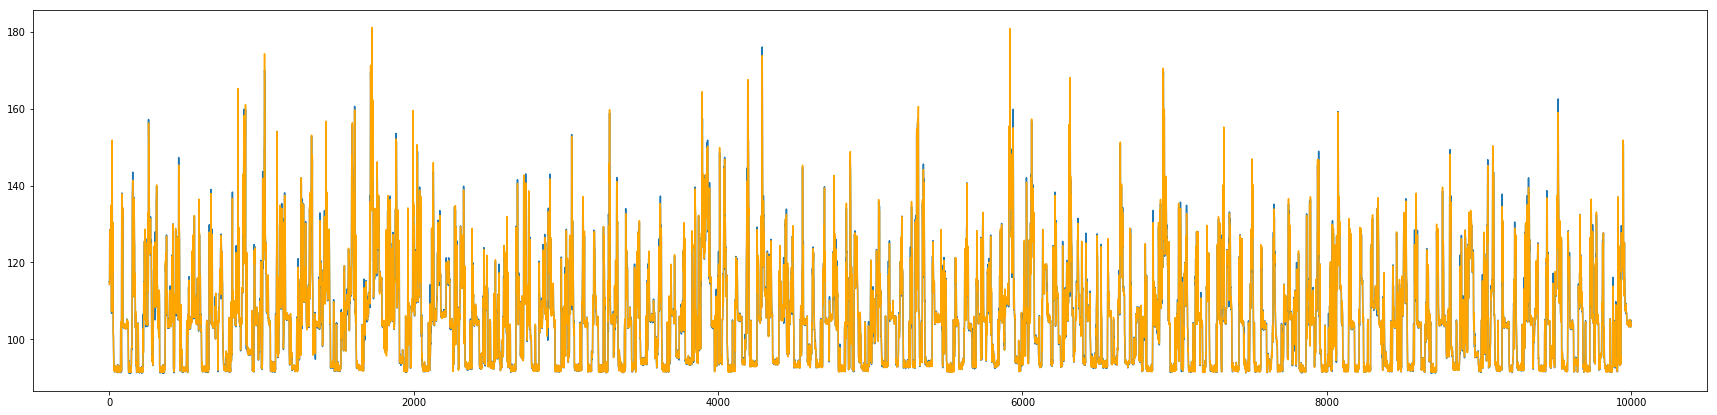

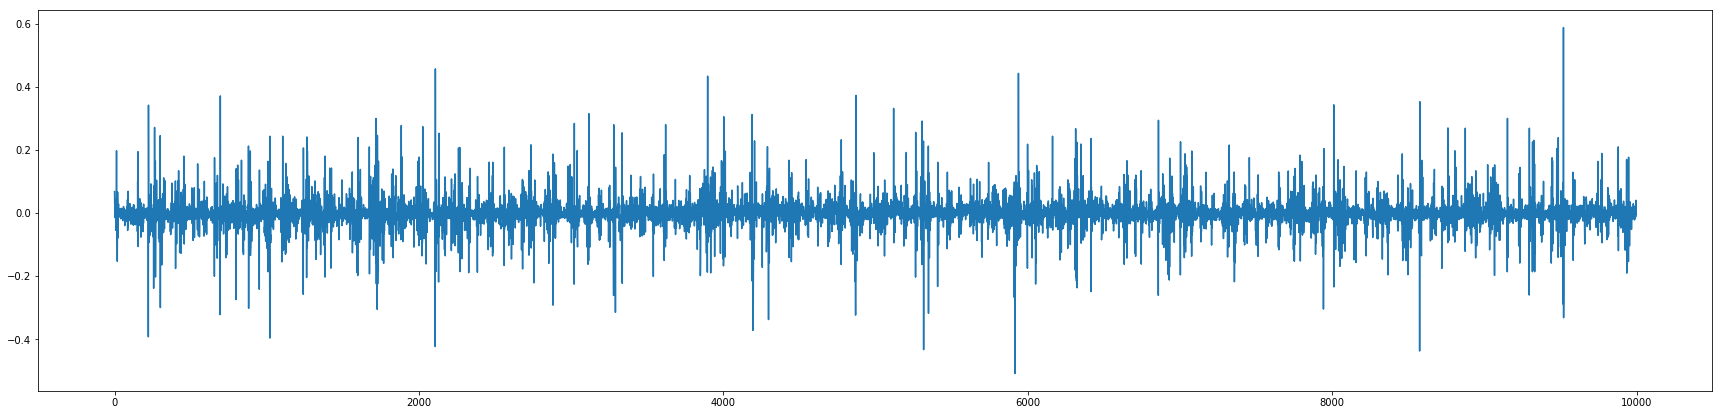

In [0]:
test_size=10000
with torch.no_grad():
  # Implementing loss function
  loss_fn = torch.nn.L1Loss()
  
  # Getting outputs  
  outputs = model(testX_tensor_5.float()[0:test_size].to(device))
  
  # Getting right labels
  labels = testY_tensor_5[0:test_size].float().view(-1, 1).to(device)
  
  # Converting outputs and labels to scaled values
  labels_inverse = labels * scaler_5.mean_[-1] + scaler_5.var_[-1]
  outputs_inverse = outputs * scaler_5.mean_[-1] + scaler_5.var_[-1]
  
  # Computing losses and r² score
  print(f"MAE = {loss_fn(outputs.data, labels)}")
  print(f"R² = {r2_score(labels.cpu(), outputs.data.cpu())}")
  print(f"MAE (real values) = {loss_fn(outputs_inverse, labels_inverse)}")
  print(f"R² (real values) = {r2_score(labels_inverse.cpu(), outputs_inverse.cpu())}")
  print("----------")
  
  # Plotting
  plt.figure(figsize=(30, 7))
  #plt.plot(outputs.data.numpy() - labels.numpy())
  #plt.plot(outputs.data.cpu().numpy())
  plt.plot(outputs.data.cpu().numpy() + mae.cpu().numpy())
  plt.plot(labels.cpu().numpy(), 'orange')
  plt.figure(figsize=(30, 7))
  plt.plot(outputs_inverse.cpu().numpy())
  plt.plot(labels_inverse.cpu().numpy(), 'orange')
  plt.figure(figsize=(30, 7))
  plt.plot(outputs.data.cpu().numpy() + mae.cpu().numpy() - labels.cpu().numpy())
with torch.no_grad():
  # Implementing loss function
  loss_fn = torch.nn.L1Loss()
  
  # Getting outputs
  outputs = model(testX_tensor_3.float()[0:test_size].to(device))
  
  # Getting right labels
  labels = testY_tensor_3[0:test_size].float().view(-1, 1).to(device)
  
  # Converting outputs and labels to scaled values
  labels_inverse = labels * scaler_3.mean_[-1] + scaler_3.var_[-1]
  outputs_inverse = outputs * scaler_3.mean_[-1] + scaler_3.var_[-1]
  
  # Computing losses and r² score
  print(f"MAE = {loss_fn(outputs.data, labels)}")
  print(f"R² = {r2_score(labels.cpu(), outputs.data.cpu())}")
  print(f"MAE (real values) = {loss_fn(outputs_inverse, labels_inverse)}")
  print(f"R² (real values) = {r2_score(labels_inverse.cpu(), outputs_inverse.cpu())}")
  print("----------")
  
  # Plotting
  plt.figure(figsize=(30, 7))
  #plt.plot(outputs.data.numpy() - labels.numpy())
  #plt.plot(outputs.data.cpu().numpy())
  plt.plot(outputs.data.cpu().numpy() + mae.cpu().numpy())
  plt.plot(labels.cpu().numpy(), 'orange')
  plt.figure(figsize=(30, 7))
  plt.plot(outputs_inverse.cpu().numpy())
  plt.plot(labels_inverse.cpu().numpy(), 'orange')
  plt.figure(figsize=(30, 7))
  plt.plot(outputs.data.cpu().numpy() - labels.cpu().numpy())

In [0]:
model = NeuralNetLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

for step in range(10):
  print(f"{step}th step")
  for i in trainX_tensor:
    optimizer.zero_grad()
    output = model(torch.unsqueeze(i, 0).float())
